# [실습 2] 감성 분석 예측기
- 학습 + 로지스틱 회귀
- Step1 : 임베딩 → 유사도 계산 → 비슷한 문장 검색 (문장을 임베딩으로 바꾼 뒤 비슷한 문장을 찾아줌)
- Step2 : 임베딩 → 모델 학습 → 긍/부정 판단 (문장을 임베딩으로 바꾼 뒤 그 문장의 감성을 예측)

## Workflow
1. NSMC 데이터를 불러온다
2. 리뷰 문장들을 임베딩으로 바꾼다.
3. 각 리뷰의 임베딩 값과 정답 라벨을 함께 준비하여 학습용 쌍을 만든다.
4. 임베딩과 라벨을 이용해 분류 모델을 학습시킨다.
5. 유저가 입력한 문장을 받는다.
6. 유저 입력 문장을 임베딩한다.
7. 학습된 모델을 사용해 긍정/부정을 예측한다.
8. 예측 결과를 라벨 및 확률로 출력한다.

# 0. 환경설정

In [ ]:
!pip -q install datasets sentence-transformers scikit-learn

# -q 다운로드내역 숨기기

In [ ]:
import numpy as np
from datasets import load_dataset
from sentence_transformers import SentenceTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import cosine_similarity

#1. 데이터셋 로드

In [ ]:
dataset = load_dataset("sepidmnorozy/Korean_sentiment", keep_in_memory=False)     # 용량 절약 옵

train_ds = dataset["train"]
test_ds  = dataset["test"]

train_df = train_ds.to_pandas()
test_df  = test_ds.to_pandas()


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


train.csv: 0.00B [00:00, ?B/s]

dev.csv: 0.00B [00:00, ?B/s]

test.csv: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/36000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1333 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2667 [00:00<?, ? examples/s]

In [ ]:
print("Train rows:", len(train_df))
print("Test rows :", len(test_df))
print(train_df.head(3))

Train rows: 36000
Test rows : 2667
   label                                      text
0      1  역시 명작 어렸을때 봤을때도 재밌었고 지금 봐도 몇억배 이상으로 재밌어요
1      0                이런 영화는 연습용으로라도 만들지말자 양심적으로
2      1                  세대 우주를 넘나드는 스카이워커가의 비극!!


#1-1. 데이터 정제하기

In [ ]:
train_df['text'].nunique(), train_df['label'].nunique()

(35992, 2)

In [ ]:
train_df.drop_duplicates(subset=['text'], inplace=True)

In [ ]:
print(len(train_df))

35992


#1-1-1.모델 예측 확률 기반 중립 생성                       (Weak Supervision)

In [ ]:
from transformers import pipeline

sentiment_pipe = pipeline(
    "sentiment-analysis",
    model="Copycats/koelectra-base-v3-generalized-sentiment-analysis",
    return_all_scores=True
)

config.json:   0%|          | 0.00/687 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/452M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/60.0 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

Device set to use cpu
/usr/local/lib/python3.12/dist-packages/transformers/pipelines/text_classification.py:111: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [ ]:
sentiment_pipe("이 영화는 좋지도 나쁘지도 않음")

[[{'label': '0', 'score': 0.17035706341266632},
  {'label': '1', 'score': 0.8296429514884949}]]

In [ ]:
sentiment_pipe("기대만큼은 아니었다")

[[{'label': '0', 'score': 0.9513667821884155},
  {'label': '1', 'score': 0.04863320291042328}]]

In [ ]:
sentiment_pipe("그냥 시간 때우기용 영화")

[[{'label': '0', 'score': 0.9903261065483093},
  {'label': '1', 'score': 0.0096738887950778}]]

In [ ]:
# 우리가 “중립”을 만드는 이유!!!
이진 감정 분석 모델은 중립 클래스를 포함하지 않기 때문에,
긍·부정이 명확하지 않은 문장도 한쪽으로 강제 분류되는 경향이 있다.
이 문장은 인간 기준으로 중립이지만,“나쁘지 않다” → 약한 긍정 패턴
한국어 감정 데이터에서는 이런 문장들이 긍정 라벨로 학습된 경우가 매우 많다
본 프로젝트에서는 이러한 한계를 보완하기 위해 예측 확률 기반으로 중립 클래스를 재정의하였다.

In [ ]:
def predict_sentiment_v2(text, low=0.35, high=0.65):
    result = sentiment_pipe(text)[0]

    label = result['label']
    score = result['score']

    # 기본은 모델 라벨을 신뢰
    if label == 'LABEL_1':
        sentiment = "긍정 😊"
    else:
        sentiment = "부정 🤬"

    # 단, 확신이 낮으면 중립
    if low < score < high:
        sentiment = "중립 😑"

    return sentiment, score


In [ ]:
train_df['new_label'] =predict_sentiment_v2(
    train_df['text'].tolist()
)

In [ ]:
train_df['new_label'].value_counts(normalize=True)

,proportion
new_label,
2,0.493776
0,0.428317
1,0.077906


In [ ]:
# 중립 리뷰 샘플 확인
train_df[train_df['new_label'] == 1].sample(15, random_state=42)['text']

,text
13628,포스터
13005,아저씨들이 왜 계속 아줌마들처럼 떠들기만할까...
19114,평점10점이 말이안되서
31949,전여잔데 감독진짜 또라이같네요 ㅎㅎ 역겹지만 중간중간 빵터짐~왤케 웃기짘ㅋ
19064,"한국만 그런 줄 알았더니, 프랑스 된장녀도 만만찮군"
8788,할말이없네...
2764,뮝미 ... 내시간아까워ㅋㅋㅋㅋ
11337,인내심 기르는데 좋은 영화인것같다 끌까말까 보는 내내 고민했고 참아냈다
33512,황진미보아라 당신은 영화를 이해못한거야 용서안할걸로 보다니
33674,쓰중쓰


In [ ]:
# 폰트설치
!apt-get install -y fonts-nanum

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.


In [ ]:
# mat 캐시 삭제(여러방법 시도 후 최종)(폰트설치 후 안되면 캐시삭제 후 런타임 재실행)
# 코랩은 런타임 이미지가 바뀌면서 기본 폰트 구성이 달라질 때가 있음
# 코랩 내장되어있는 기본 한글폰트 Noto Sans CJK KR

!rm -rf ~/.cache/matplotlib

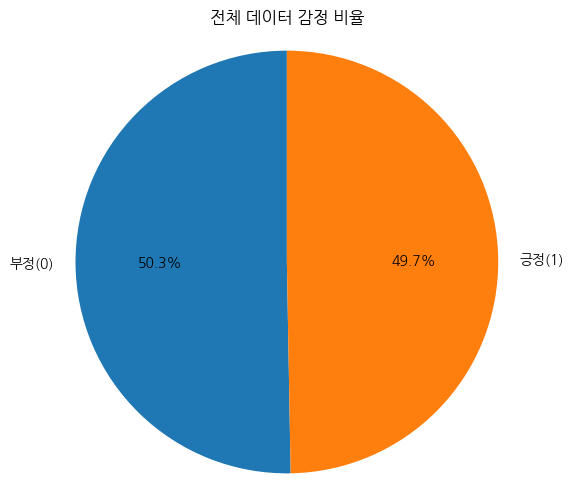

In [ ]:
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

label_counts = train_df['label'].value_counts().sort_index()
labels = ['부정(0)', '긍정(1)']

plt.figure(figsize=(6, 6))
plt.pie(
    label_counts,
    labels=labels,
    autopct='%1.1f%%',
    startangle=90
)
plt.title('전체 데이터 감정 비율')
plt.axis('equal')
plt.show()


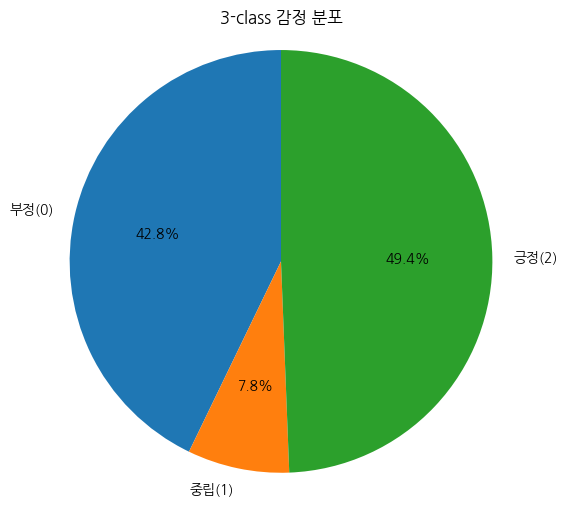

In [ ]:
import matplotlib.pyplot as plt

label_counts = train_df['new_label'].value_counts().sort_index()
labels = ['부정(0)', '중립(1)', '긍정(2)']

plt.figure(figsize=(6, 6))
plt.pie(
    label_counts,
    labels=labels,
    autopct='%1.1f%%',
    startangle=90
)
plt.title('3-class 감정 분포')
plt.axis('equal')
plt.show()

#2. 임베딩

In [ ]:
st_model = SentenceTransformer("Copycats/koelectra-base-v3-generalized-sentiment-analysis")

def embed_dataset(split):
    texts = split["text"]
    embeddings = st_model.encode(
        texts,
        batch_size=64,       #전체데이터 중 위의 64개 학습해! 전체 데이터셋을 입력시키면 오래걸리고 힘드니
        show_progress_bar=True
    )
    labels = np.array(split["label"])
    return embeddings, labels

X_train, y_train = embed_dataset(train_ds)
X_test,  y_test  = embed_dataset(test_ds)

Batches:   0%|          | 0/563 [00:00<?, ?it/s]

Batches:   0%|          | 0/42 [00:00<?, ?it/s]

#3. 로지스틱 회귀로 모델학습

In [ ]:
clf = LogisticRegression(
    max_iter=2000,      #최대 2000번 학습하여라
    n_jobs=-1           #연결된 자원을 최대한 활용해라 -1이 최대치를 의미
)
clf.fit(X_train, y_train)     #fit 학습시키는 명령어, 무조건 train으로 학습!

LogisticRegression(max_iter=2000, n_jobs=-1)

#4. 테스트셋 평가

In [ ]:
test_pred = clf.predict(X_test)             #pred 시험...... 현업에서 90% 목표화
print("Test accuracy:", accuracy_score(y_test, test_pred))

Test accuracy: 0.9418822647169104


#5. 유저쿼리에 대한 감성 예측 함수 만들기

In [ ]:
label_map = {0: "부정 🤬", 1: "중립 😑", 2: "긍정 🙂"}

def predict_sentiment(text: str):
    emb = st_model.encode([text])
    pred = clf.predict(emb)[0]
    proba = clf.predict_proba(emb)[0][pred]
    return label_map[pred], float(proba)

#6. 유저 테스트

In [ ]:
s, p = predict_sentiment("나의 인생 영화임")
print(f"예측: {s} (확률 {p:.3f})")

예측: 긍정 🙂 (확률 0.974)


In [ ]:
examples = [
    "스토리도 탄탄하고 배우 연기도 좋아서 끝까지 몰입해서 봤다.",
    "스토리도 산만하고 전개가 너무 지루해서 힘들었다.",
    "특별히 기억에 남는 장면은 없지만 시간은 잘 갔다. "
]

for t in examples:
    s, p = predict_sentiment(t)
    print(f"문장: {t}\n → 예측: {s} (확률 {p:.3f})\n")

문장: 스토리도 탄탄하고 배우 연기도 좋아서 끝까지 몰입해서 봤다.
 → 예측: 중립 😑 (확률 0.992)

문장: 스토리도 산만하고 전개가 너무 지루해서 힘들었다.
 → 예측: 부정 🤬 (확률 0.999)

문장: 특별히 기억에 남는 장면은 없지만 시간은 잘 갔다. 
 → 예측: 중립 😑 (확률 0.517)



In [ ]:
examples = [
    "지루할 틈 없이 전개가 빠르고 감동도 있어서 좋았다.",
    "끝까지 다 봤지만 왜 봤는지 모르겠다는 생각이 들었다.",
    "기대를 크게 안 해서인지 그냥 그럭저럭 볼 만했다. "
]

for t in examples:
    s, p = predict_sentiment(t)
    print(f"문장: {t}\n → 예측: {s} (확률 {p:.3f})\n")

문장: 지루할 틈 없이 전개가 빠르고 감동도 있어서 좋았다.
 → 예측: 중립 😑 (확률 0.994)

문장: 끝까지 다 봤지만 왜 봤는지 모르겠다는 생각이 들었다.
 → 예측: 부정 🤬 (확률 0.943)

문장: 기대를 크게 안 해서인지 그냥 그럭저럭 볼 만했다. 
 → 예측: 부정 🤬 (확률 0.905)

